# Import dependencies

In [1]:

import numpy as np
import scipy
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation, buildControlFunctionAdjoint
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax, calculateFirstDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep
from src.semiSmoothWalter import computeSSNStepWalter

# Set parameters

In [2]:
@dataclass
class Parameters:
    T = 1
    verbose = True
    useDummy = False
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 2e-9
    beta = 1e-7
    waveSpeed = 1
    randomFactor = 5
    maxIterations = 50
    pruneThreshold = 0
    maxNewtonSteps = 50
    newton_c = 5
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

# Setup problem

In [3]:
def setupObservation(s1, s2, params):
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	control = buildControlFunction([g1, g2], [s1, s2], params)
	if not params.useDummy:
		K_u = solveStateEquation(control, params)
	else:
		K_u = control
	grid_size = K_u[0].x.array.shape
	raw_matrices = [K_u_t.x.array for K_u_t in K_u]
	norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
	scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
	np.random.seed(42)
	yd = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(yd)):
		yd[idx].x.array[:] = K_u[idx].x.array + 0#np.random.normal(loc=0.0, scale=scale, size=grid_size)
	params.yd = yd
	if not params.useDummy:
		params.yd_adjoint = solveAdjointEquation(params.yd, params)
	else:
		params.yd_adjoint = params.yd
	#timeDependentVariableToGif(yd, 'output/observation.gif', T=params.T)


# Minimization algorithm

In [4]:
def algorithm(active_set_init, weights_init, slope_init, y_shift_init, params):
	active_set = []
	active_set[:] = active_set_init
	hesse = HesseMatrix(active_set, params)
 
	if params.verbose:
		print('Objective upper bound: ', computeObjective(np.concatenate((weights_init, slope_init, y_shift_init)), active_set_init, hesse.standard_states, params))
	weights = np.copy(weights_init)
	slope = np.copy(slope_init)
	y_shift = np.copy(y_shift_init)
	constraintViolation = np.empty(params.maxIterations)
	constraintViolation[:] = np.nan
	weights, slope, y_shift = computeSSNStepWalter(weights, slope, y_shift, active_set, hesse, params)
	#weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
	if params.verbose:
		print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
	timePoints = np.linspace(0, params.T, num=len(params.yd))

	for k in range(params.maxIterations):
		discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse, params)
		if params.verbose:
			printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
			showNonStationarity(discreteDf, active_set, params)
		p_k = integrateVectorFunction(discreteDf, params)
  		#p_k = calculateFirstDual(active_set, weights, slope, y_shift, hesse.standard_firstDual, params)
		#P_k = -integrateVectorFunction(p_k, params
		#p_k = discreteDf * timePoints[:, np.newaxis]
		P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params)
		if params.verbose:
			u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
			fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
			plot_array(discreteDf, params.T, label='grad', ax=ax1)
			ax2.plot(timePoints, np.linalg.norm(p_k, axis=1)/params.alpha, marker='o', linestyle='-', color='b', label='|p_k|/alpha')
			ax3.plot(timePoints, np.linalg.norm(P_k, axis=1)/params.beta, marker='o', linestyle='-', color='b', label='|P_k|/beta')
			#plot_array(np.linalg.norm(p_k)/params.alpha, params.T, label='p_k', ax=ax2)
			#plot_array(np.linalg.norm(P_k)/params.beta, params.T, label='P_k', ax=ax3)
			plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
			mpl.pyplot.show()
			print('VALUES DUAL END FIRST: ', p_k[-1], 'SECOND: ', P_k[-1])

		idx_S = getIdxMax(p_k, discreteDf, active_set, type=0)
		idx_K = getIdxMax(P_k, -p_k, active_set, type=1)
		norm_p_max = np.linalg.norm(p_k[idx_S])
		norm_P_max = np.linalg.norm(P_k[idx_K])
		if params.verbose:
			print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
		constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
		if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
			break
		if norm_p_max / params.alpha >= norm_P_max / params.beta:
			active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
		else:
			active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))
		if params.verbose:
			print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
		hesse.extendMatrix(active_set[-1])
		weights, slope, y_shift = computeSSNStepWalter(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		#weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		if params.verbose:
			print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
		hesse.pruneMatrix(active_set, weights)
		if params.verbose:
			print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
	return active_set, weights, slope, y_shift, constraintViolation


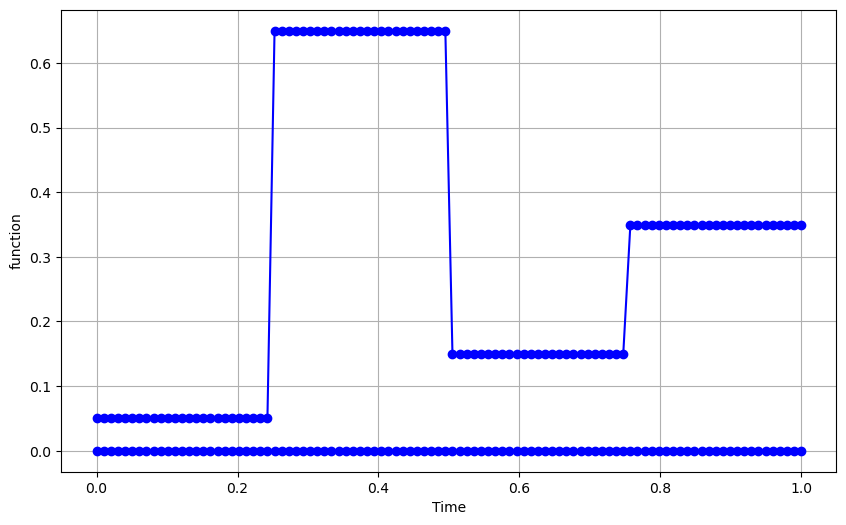

Test for alpha= 1e-09 , beta= 0.1
Objective upper bound:  0.001894226924224738
weights:  [] slope:  [0.3515199  0.00610493] y_shift [ 0.17276763 -0.00280717]
Objective:  5.339999065285992e-06
0 : Active set:
slope:  [0.3515199  0.00610493] y_shift [ 0.17276763 -0.00280717]
0 : Hesse condition: 72.93286783139075
First conditions:  [ 7.61422066e-10 -3.10232711e-12 -4.41988935e-07  2.00915483e-09]  (should be close to 0)
Second conditions:  []  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 1864), Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 1869), Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset

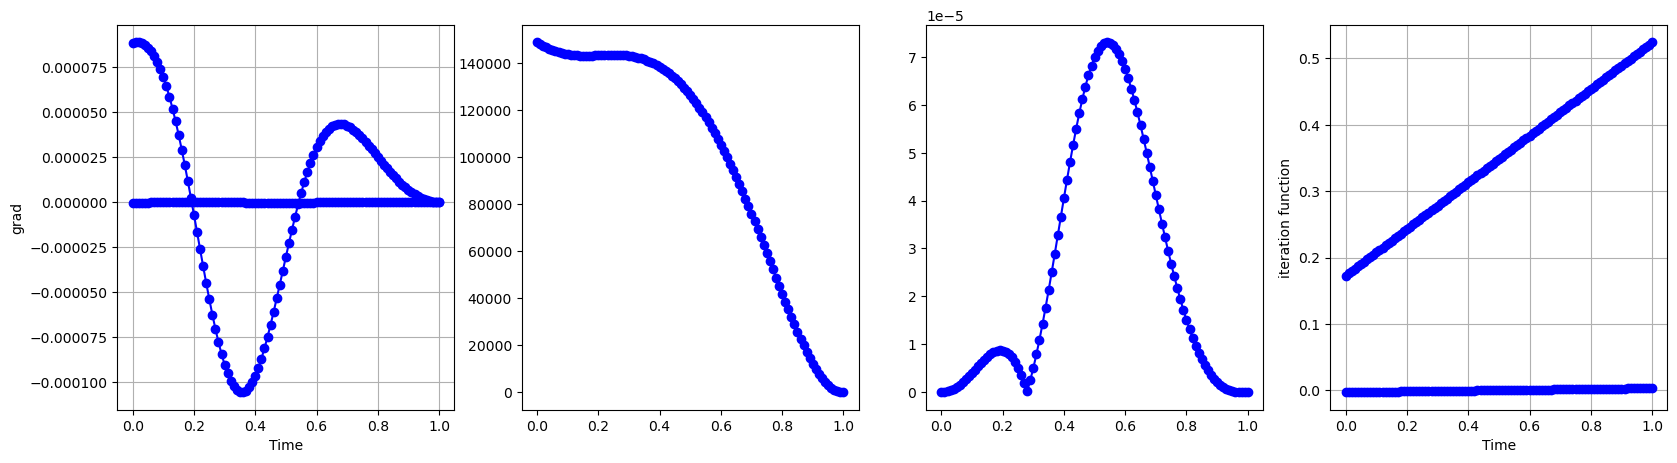

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [ 7.61422066e-10 -3.10232711e-12]
|p_max|/alpha:  148084.8764129472 , |P_max|/beta:  7.302695591005465e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.9998027  0.01986346] x_0 = 0.01 , type = 0
weights:  [4.01103848] slope:  [ 0.02871294 -0.00629781] y_shift [-3.66225922 -0.07595982]
Objective:  3.5598022094089336e-06
1 : Active set:
	 0 sigma= [0.9998027  0.01986346] ,	x_0 = 0.01 ,	type = 0 	weight: 4.011038483111152 	id: 140070619560752
slope:  [ 0.02871294 -0.00629781] y_shift [-3.66225922 -0.07595982]
1 : Hesse condition: 24347.797950455053
First conditions:  [ 7.07739379e-12 -1.89289092e-11  3.84928498e-09  1.13352384e-08]  (should be close to 0)
Second conditions:  [1.]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 4843), Coefficient(FunctionSpac

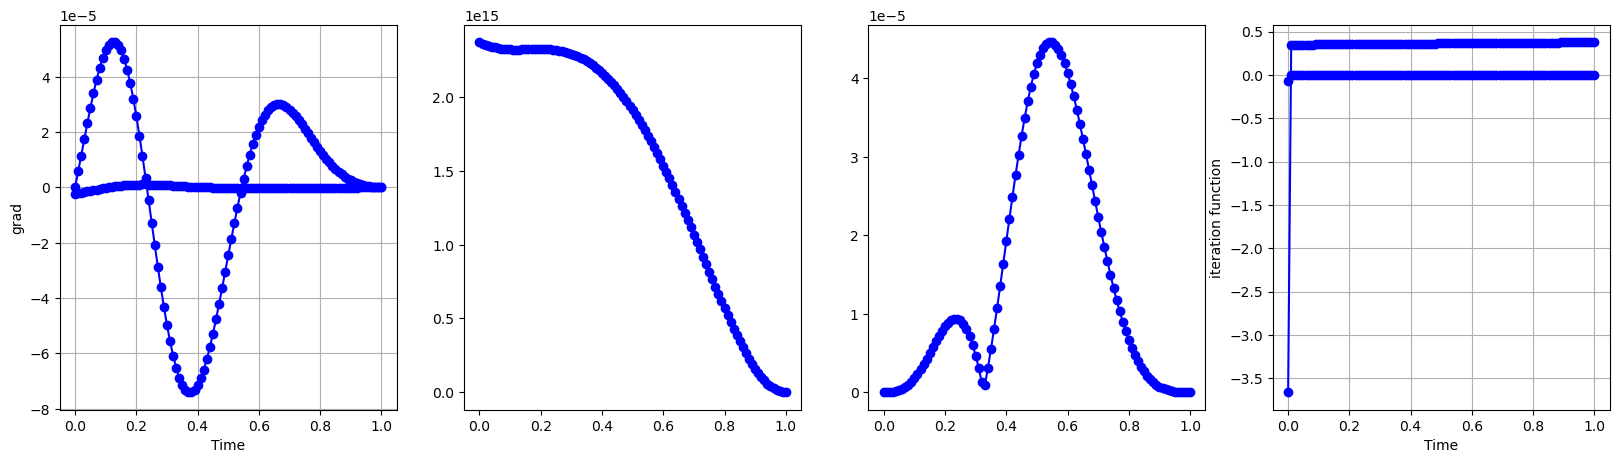

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [ 7.07739379e-12 -1.89289092e-11]
|p_max|/alpha:  2353239227796445.0 , |P_max|/beta:  4.456291793591095e-05
x_S:  0.02 x_K:  0.54 
New point: sigma= [0.99890759 0.04672939] x_0 = 0.02 , type = 0
weights:  [0.         2.12998404] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.450759166631948e-06
2 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.129984043920234 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
2 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371412e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Coeff

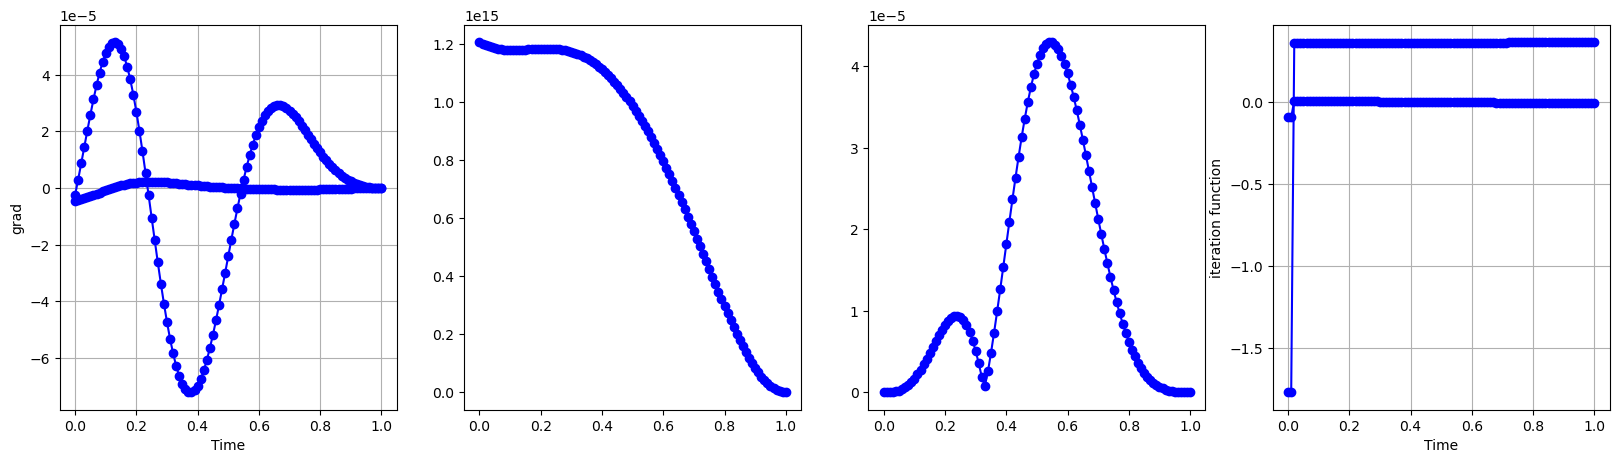

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371412e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232201.8 , |P_max|/beta:  4.297050336456523e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0
weights:  [2.12998404 0.        ] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.450759166631948e-06
3 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.129984043920105 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
3 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371411e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Coeff

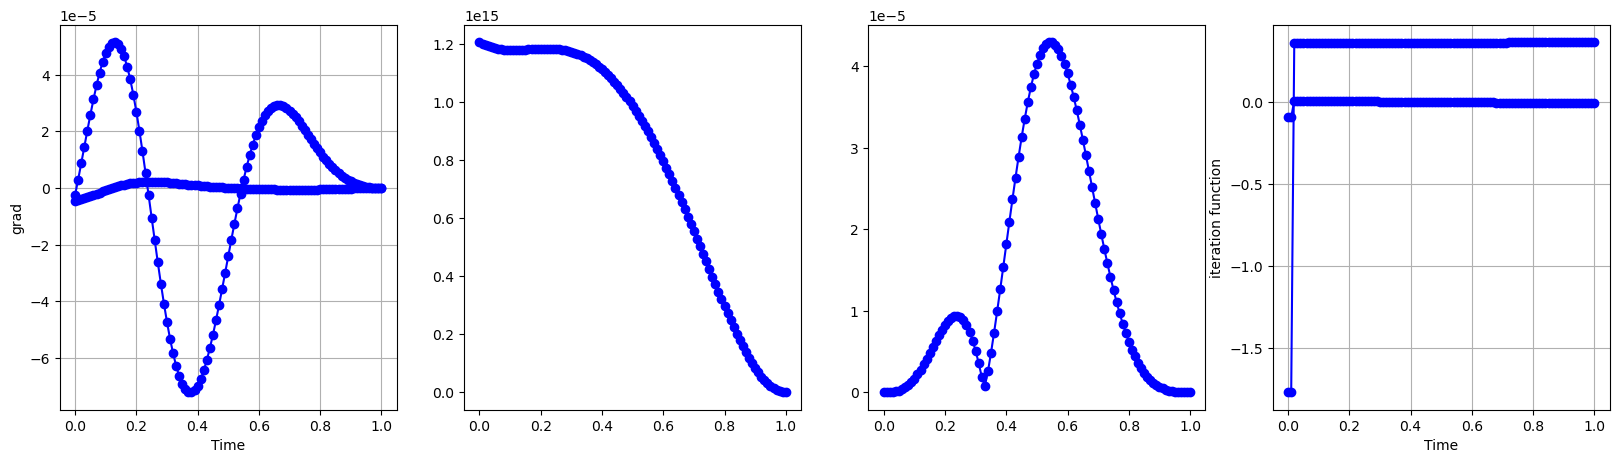

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371411e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232133.8 , |P_max|/beta:  4.29705033645653e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0
weights:  [2.12998404 0.        ] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.4507591666319484e-06
4 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.1299840439199618 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
4 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371411e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Coef

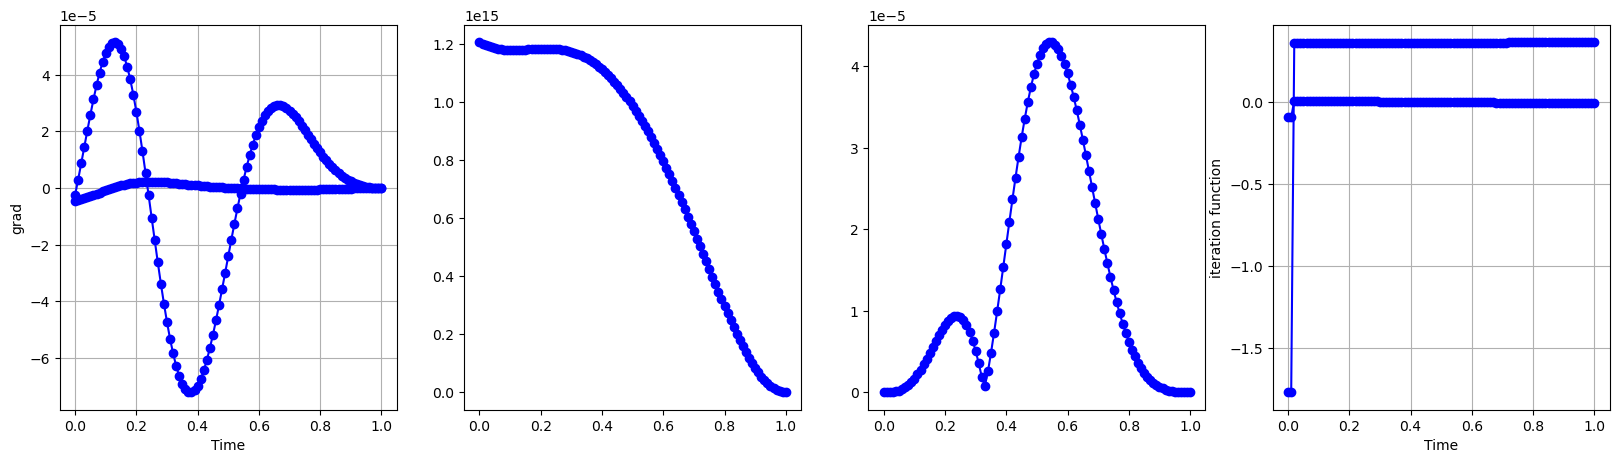

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371411e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232052.0 , |P_max|/beta:  4.297050336456713e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0
weights:  [2.12998404 0.        ] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.450759166631948e-06
5 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.1299840439202242 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
5 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371410e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Coef

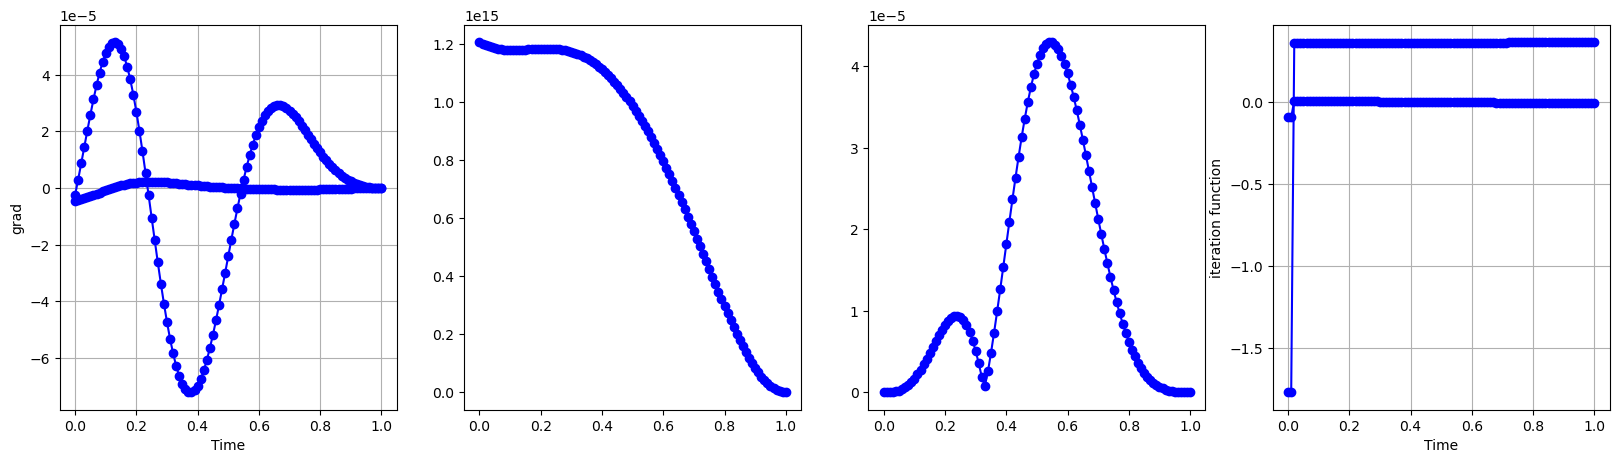

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371410e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232198.8 , |P_max|/beta:  4.297050336456423e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0
weights:  [2.12998404 0.        ] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.4507591666319484e-06
6 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.1299840439206714 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
6 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371414e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Coe

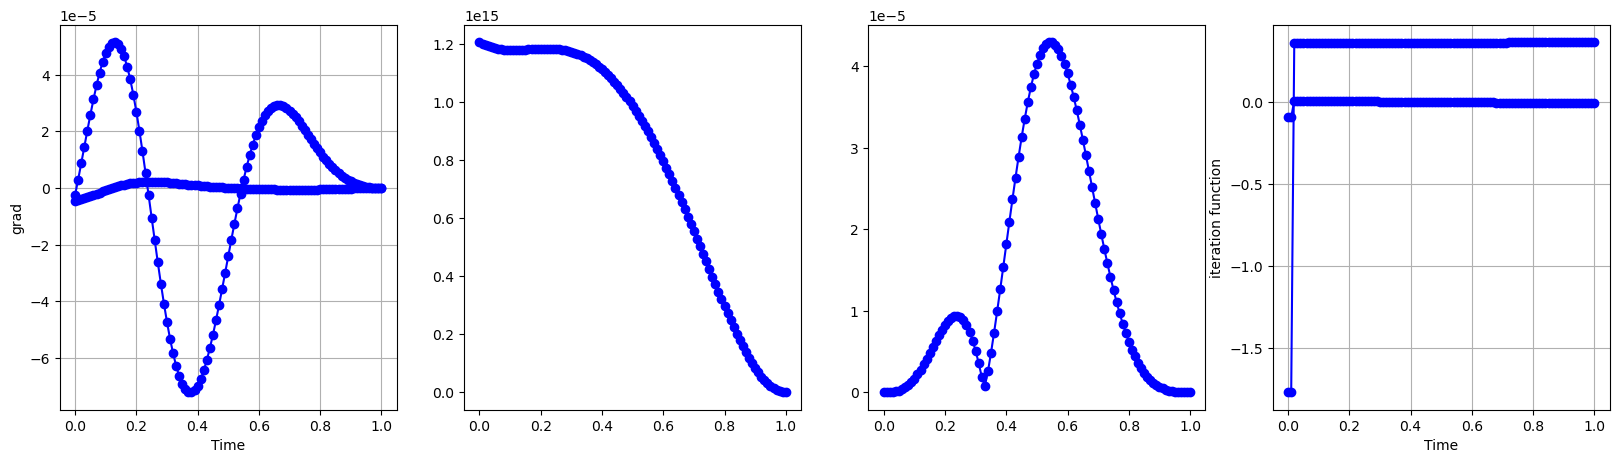

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371414e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232457.0 , |P_max|/beta:  4.2970503364558386e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0
weights:  [2.12998404 0.        ] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.4507591666319505e-06
7 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.1299840439200555 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
7 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371410e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Co

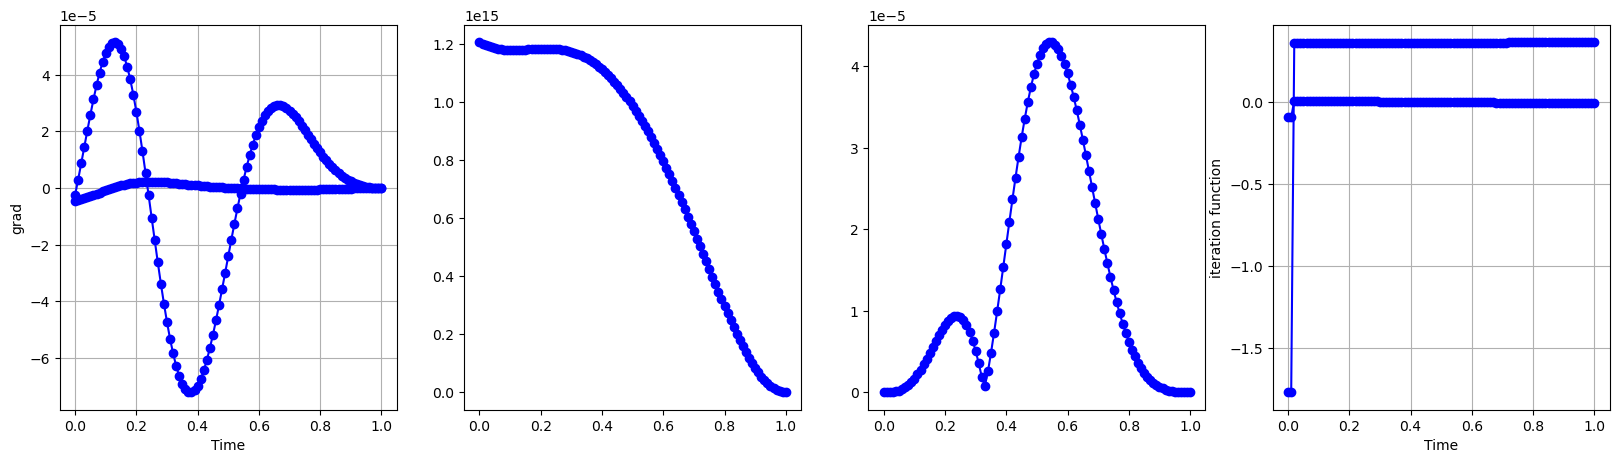

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371410e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232101.8 , |P_max|/beta:  4.297050336456596e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0
weights:  [2.12998404 0.        ] slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
Objective:  3.4507591666319484e-06
8 : Active set:
	 0 sigma= [0.99890759 0.04672939] ,	x_0 = 0.02 ,	type = 0 	weight: 2.1299840439199897 	id: 140070618575744
slope:  [ 0.00585011 -0.01612627] y_shift [-1.76794472 -0.09053392]
8 : Hesse condition: 6134.1388857210895
First conditions:  [-1.57371411e-11 -4.01790506e-11  1.67872003e-08  2.38634600e-08]  (should be close to 0)
Second conditions:  [0.99999999]  (should be greater or equal than 0)
[]
[Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 6892), Coe

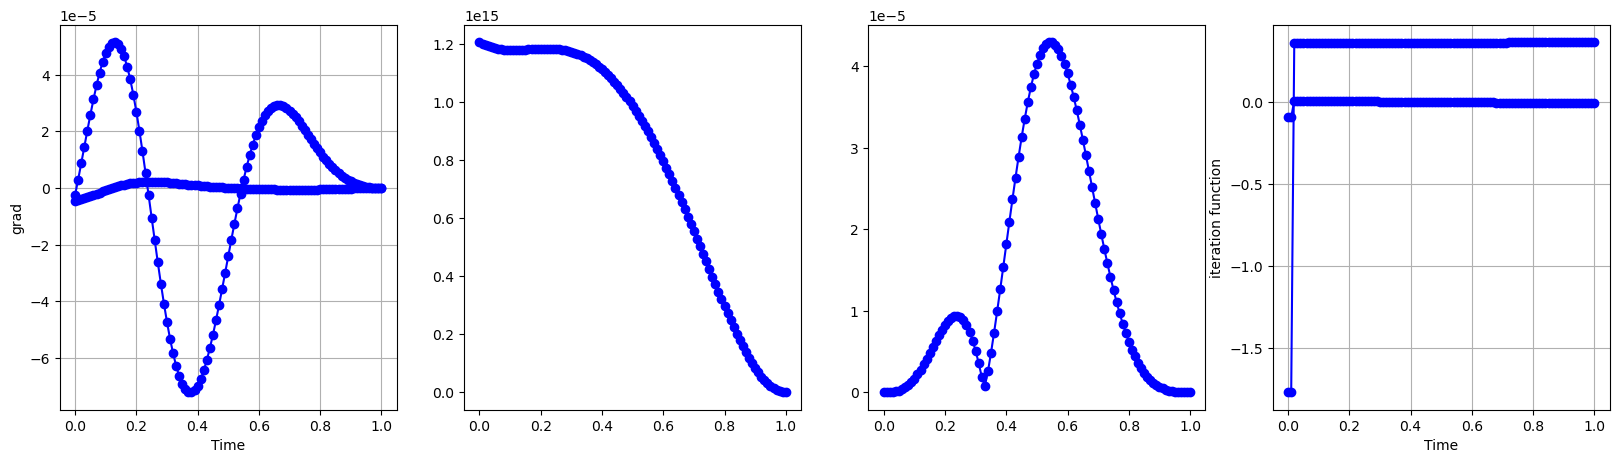

VALUES DUAL END FIRST:  [0. 0.] SECOND:  [-1.57371411e-11 -4.01790506e-11]
|p_max|/alpha:  1201777728232070.8 , |P_max|/beta:  4.2970503364567046e-05
x_S:  0.01 x_K:  0.54 
New point: sigma= [0.99721755 0.07454639] x_0 = 0.01 , type = 0


In [5]:
def testRegularizationParameters(alpha, beta, params, originalSignal):
    params.alpha = alpha
    params.beta = beta
    print('Test for alpha=', alpha, ', beta=', beta)
    active_set = []
    weights = np.ones(len(active_set))
    slope = np.ones(params.d)
    y_shift = np.ones(params.d)    
    active_set, weights, slope, y_shift, constraintViolation = algorithm(active_set, weights, slope, y_shift, params)
    printIterationInfo(0, active_set, weights, slope, y_shift, np.identity(1))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    u_fin = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    reconstruction = np.array([u_fin(t) for t in timePoints])
    fig, (ax1, ax2) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(timePoints, originalSignal[:, 0], label='u(t)')
    ax1.plot(timePoints, reconstruction[:, 0], label='$\tilde{u}(t)$')
    ax2.plot(timePoints, originalSignal[:, 1], label='u(t)')
    ax2.plot(timePoints, reconstruction[:, 1], label='$\tilde{u}(t)$')
    mpl.pyplot.show()
    mpl.pyplot.yscale('log')
    mpl.pyplot.plot(constraintViolation)
    mpl.pyplot.show()

params.maxIterations = 20
params.newton_c = 1
params.maxNewtonSteps = 50
params.pruneThreshold = 0
params.verbose = True
params.mollify_const = 0.1
s1 = lambda t : (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
#s1 = lambda t : #(0.05*t if t <= 0.25 else (0.90*t + 1 if t <= 0.5 else -2 - 0.95*t if t <= 0.75 else 0.3)) #/ params.alpha
s2 = lambda t : 0#(0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)))
setupObservation(s1, s2, params)

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
gradient_test = buildControlFunctionAdjoint([g1, g2], solveAdjointEquation(params.yd, params), params)
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in timePoints])
array[:, 1] = np.array([s2(t) for t in timePoints])
plot_array(array, params.T)

# test if adjoint operator is precise
# print(calculateL2InnerProduct(params.yd, params.yd, params))
# print(array[:,0].dot(gradient_test[1:,0])/100 + array[:,1].dot(gradient_test[1:,1])/100)
testRegularizationParameters(1e-9, 1e-1, params, array)
#testRegularizationParameters(5e-8, 1e-8, params, array)